# NHL MVP Analysis

This project is a first foray into machine learning. The goal is to predict player's vote share of the Hart trophy, which is awarded to the most valuable player in the National Hockey League as voted on by members of the Professional Hockey Writer's Association.  

Hockey statistics come from Evolving Hockey and Hockey-Reference. At the moment only basic statistics provided in the Hart trophy candidates by year summary page from Hockey-Reference are used. A medium term goal is to scrape data including advanced statistics to combine with the existing data. It is somewhat challenging to give an accurate prediction based only on the basic statistics used so far. In some cases it's really not the model's fault and vote share outliers are determined by factors beyond the basic statistics used so far (this could be things such as advanced statistics that we don't currently use, or things like narratives surrounding a team's season which a model trained on statistics will never be able to incorporate). The methodology used in this notebook is heavily inspired by Kaggle style projects in the sense that rather than spend a lot of time designing one very good model, several slightly-optimized models are trained and then stacked by i.e. xgboost. 

References/Acknowledgements:
Most of what appears in this notebook was learned/borrowed from Kaggle. In particular, two specific notebooks I heavily referenced are https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python and https://www.kaggle.com/mmueller/stacking-starter.

To do: grid search hyperparameter optimization for base models and stack

In [354]:
# imports
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import os
import time
import csv 
import sklearn
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import warnings

import xgboost as xgb

from sklearn.ensemble import (RandomForestRegressor,  ExtraTreesRegressor)
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.model_selection import (KFold, train_test_split, cross_val_score)
from sklearn.metrics import (mean_absolute_error)
from sklearn.pipeline import make_pipeline

from xgboost import XGBRegressor
from bs4 import BeautifulSoup


warnings.filterwarnings('ignore')
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

%matplotlib inline
py.init_notebook_mode(connected=True)
pd.set_option('display.max_columns', 500)
os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [355]:
try:
    full_data= pd.read_csv("hockey-data-hart.csv")    
except:
    # Scrape data
    # specify the url
    years = range(1936,2018 + 1)
    addresses = ["https://www.hockey-reference.com/awards/voting-{}.html#all-hart-stats".format(yr) for yr in years]
    names = ['Year',  
             'player',
             'age',
             'team_id',
             'pos',
             'votes',
             'pct_of_vote',
             'first',
             'second',
             'third',
             'fourth',
             'fifth',
             'goals',
             'assists',
             'points',
             'plus_minus',
             'wins_goalie',
             'losses_goalie',
             'ties_goalie',
             'goals_against_avg',
             'save_pct',
             'ops',
             'dps',
             'gps',
             'ps']

    with open('hockey-data-hart.csv', 'w') as csvfile:    #Create the csv file
        hockeywriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        hockeywriter.writerow(names)
        for i, pg in enumerate(addresses):
            time.sleep(0.1) #pause the code for a sec
            r = requests.get(pg)
            # parse the html using beautiful soup and store in variable `soup`
            soup = BeautifulSoup(r.text, "html.parser")
            values = [years[i]]  #first value

            #Go through the stats and add them to a list
            for tag in soup.findAll("td"):
                if tag.string == 'None': #don't save 'None' string
                    values.append('') 
                elif tag['data-stat']=='team_id': #use proper team name
                    try: #though it may not exist
                        values.append(tag.contents[0]['title'])
                    except:
                        values.append(tag.string)
                else:
                    values.append(tag.string)
                if tag['data-stat']=='ps': #if last value in row start on next line
                    hockeywriter.writerow(values)
                    values = [years[i]]  #set first value again     

In [356]:
full_data= pd.read_csv("hockey-data-hart.csv")    


# clean it up
full_data=full_data.dropna(axis=0,subset=['pct_of_vote'])
full_data=full_data.drop(['first','second','third','fourth','fifth'],axis=1)
full_data = full_data[full_data["pct_of_vote"]>0]

# let's also drop goalies who are missing save pct, and skaters who are missing plus_minus
full_data = full_data.loc[~((full_data.pos=="G") & full_data.save_pct.isna())]
full_data = full_data.loc[~((full_data.pos!="G") & full_data.plus_minus.isna())]

# remaining na's should be due to mismatched position with stats. set them to zero
full_data = full_data.fillna(0)

# for non goalies (goalies), let's replace all goalie (non goalie) stats by zero rather than NaN

# Create a new feature p_simp: for players who have joint positions, we just keep the first one
def pos_combine(name):
    title_search = re.search('(^[A-Z]{1,2})', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

full_data["pos"] = full_data["pos"].apply(pos_combine)

# add a new column
full_data["ga"] = full_data["goals"]*full_data["assists"]/np.sqrt(full_data["goals"].mean()*full_data["assists"].mean())

# in some sense the following is a hyperparameter which we should perhaps learn
full_data = full_data[full_data["pct_of_vote"]>2]

skaters = full_data[full_data['pos']!='G']
goalies = full_data[full_data['pos']=='G']
   
full_data.tail(20)

,Year,player,age,team_id,pos,votes,pct_of_vote,goals,assists,points,plus_minus,wins_goalie,losses_goalie,ties_goalie,goals_against_avg,save_pct,ops,dps,gps,ps,ga
1005,2016,Erik Karlsson,25,Ottawa Senators,D,44,2.93,16,66,82,-2.0,0.0,0.0,0.0,0.00,0.000,8.4,3.2,0.0,11.7,32.494349
1006,2016,Ben Bishop,29,Tampa Bay Lightning,G,42,2.80,0,1,1,0.0,35.0,21.0,4.0,2.06,0.926,0.0,0.0,12.2,12.2,0.000000
1020,2017,Connor McDavid,20,Edmonton Oilers,C,1604,96.05,30,70,100,27.0,0.0,0.0,0.0,0.00,0.000,9.7,3.0,0.0,12.8,64.619444
1021,2017,Sidney Crosby,29,Pittsburgh Penguins,C,1104,66.11,44,45,89,17.0,0.0,0.0,0.0,0.00,0.000,10.5,1.7,0.0,12.3,60.926904
1022,2017,Sergei Bobrovsky,28,Columbus Blue Jackets,G,469,28.08,0,0,0,0.0,41.0,17.0,5.0,2.06,0.931,0.0,0.0,14.9,14.9,0.000000
1023,2017,Brent Burns,31,San Jose Sharks,D,273,16.35,29,47,76,19.0,0.0,0.0,0.0,0.00,0.000,8.9,6.4,0.0,15.3,41.941096
1024,2017,Erik Karlsson,26,Ottawa Senators,D,258,15.45,17,54,71,10.0,0.0,0.0,0.0,0.00,0.000,7.2,5.7,0.0,12.9,28.247928
1025,2017,Patrick Kane,28,Chicago Blackhawks,RW,206,12.34,34,55,89,11.0,0.0,0.0,0.0,0.00,0.000,8.7,2.1,0.0,10.8,57.542076
1026,2017,Brad Marchand,28,Boston Bruins,LW,184,11.02,39,46,85,18.0,0.0,0.0,0.0,0.00,0.000,9.8,2.8,0.0,12.6,55.203467
1027,2017,Nikita Kucherov,23,Tampa Bay Lightning,RW,119,7.13,40,45,85,13.0,0.0,0.0,0.0,0.00,0.000,9.7,2.2,0.0,12.0,55.388094


             Year         age        votes  pct_of_vote       goals  \
count   458.00000  458.000000   458.000000   458.000000  458.000000   
mean   1992.00655   27.694323   168.967249    22.216659   29.244541   
std      17.07180    4.496341   273.617466    25.091422   20.844250   
min    1956.00000   18.000000     7.000000     2.030000    0.000000   
25%    1977.00000   24.250000    28.000000     4.745000   11.000000   
50%    1996.00000   27.000000    58.000000    10.955000   32.000000   
75%    2006.00000   30.000000   171.750000    30.602500   45.000000   
max    2018.00000   43.000000  1604.000000   100.000000   92.000000   

          assists      points  plus_minus  wins_goalie  losses_goalie  \
count  458.000000  458.000000  458.000000   458.000000     458.000000   
mean    44.565502   73.810044   19.375546     7.962882       4.406114   
std     29.960972   47.613976   22.045279    14.886615       8.495135   
min      0.000000    0.000000  -15.000000     0.000000       0.00000

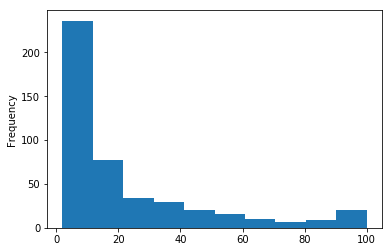

In [357]:
print(full_data.describe())
full_data['pct_of_vote'].plot.hist()

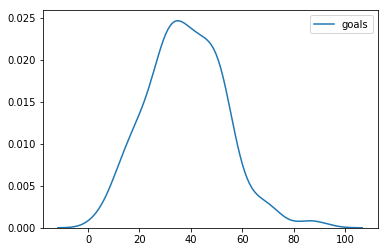

<Figure size 432x288 with 0 Axes>

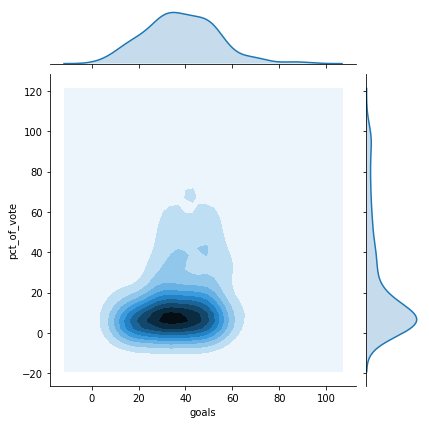

In [358]:
fig = plt.figure()
sns.kdeplot(skaters['goals'])
fig = plt.figure()
sns.jointplot(x='goals',y='pct_of_vote',data = skaters, kind='kde', gridsize=40)

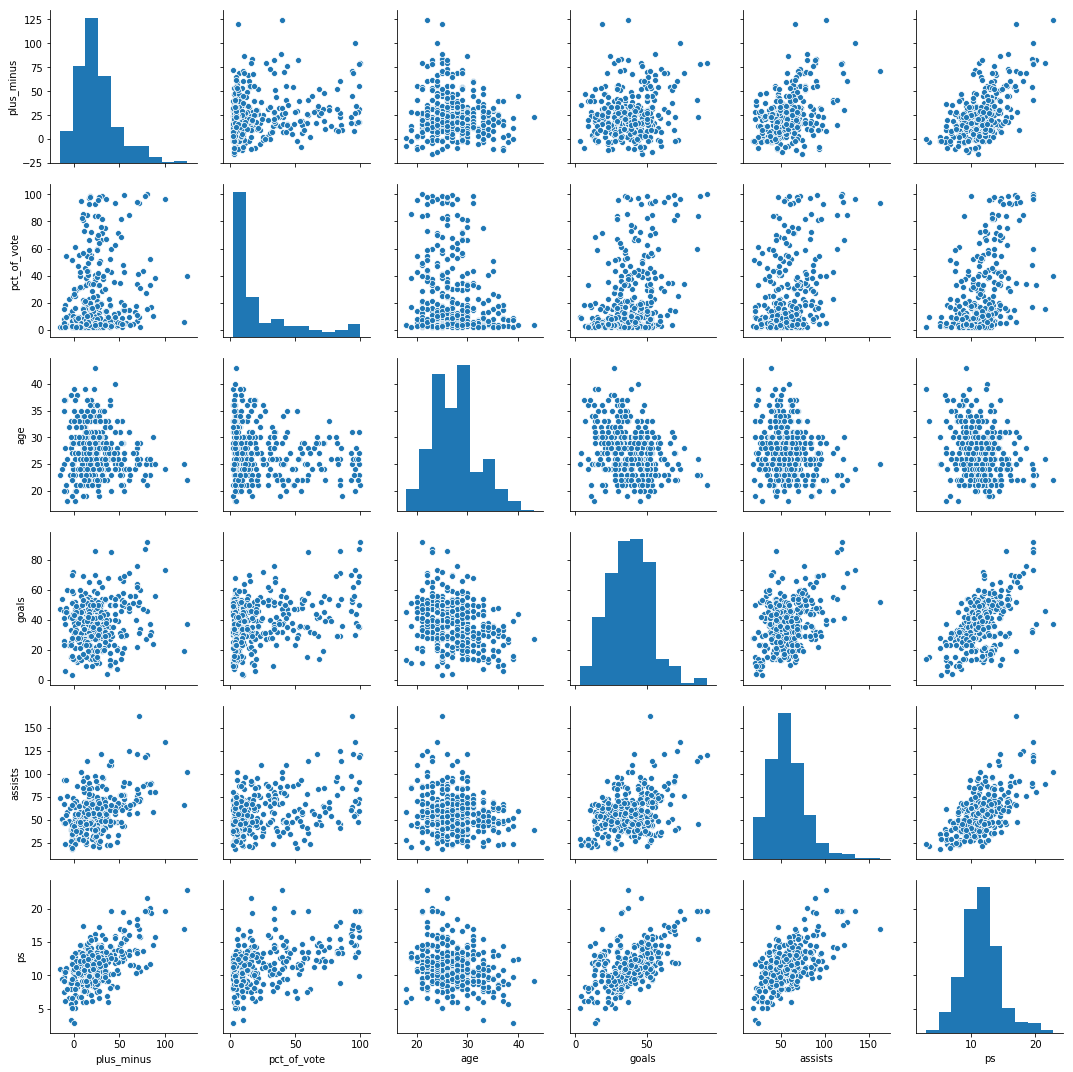

In [359]:
# examining some skater data
sns.pairplot(skaters[['plus_minus','pct_of_vote','age','goals', 'assists','ps']])

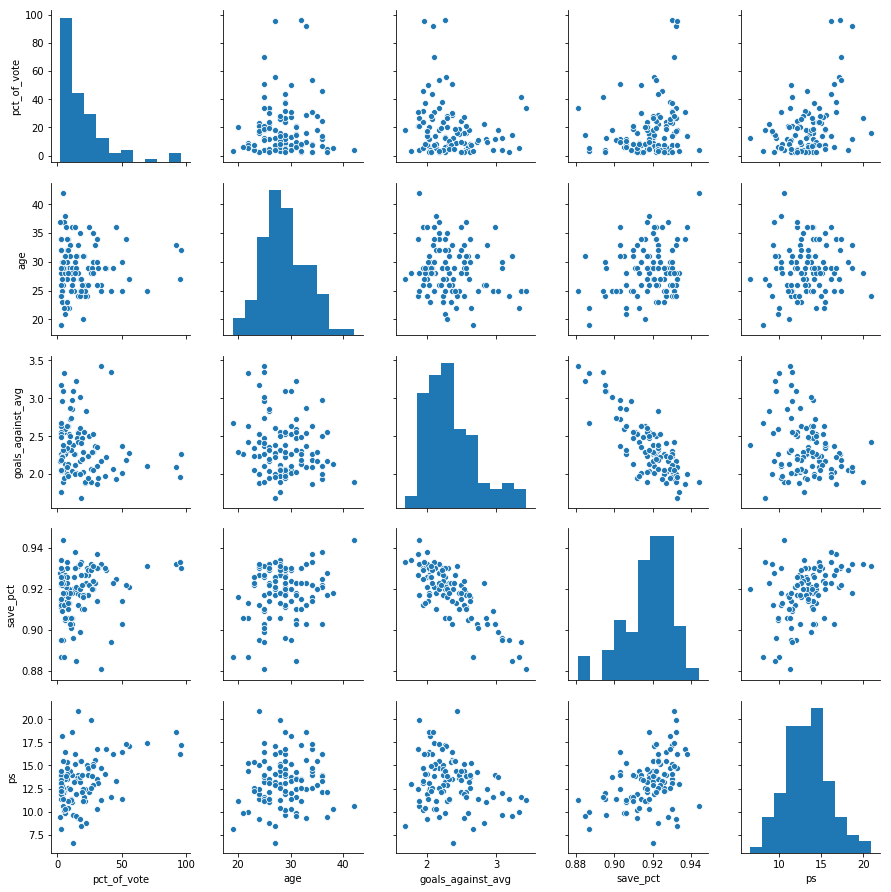

In [360]:
# examining some goalie data
sns.pairplot(goalies[['pct_of_vote','age','goals_against_avg','save_pct','ps']])

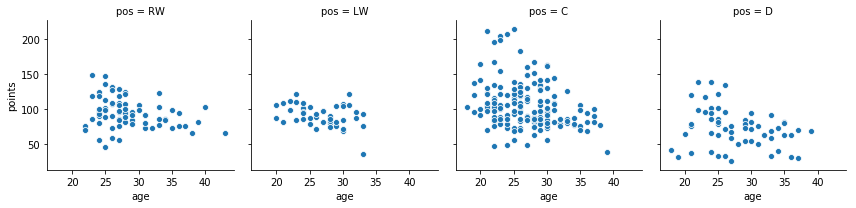

In [361]:
g = sns.FacetGrid(skaters,col="pos")
g.map(sns.scatterplot, 'age','points')

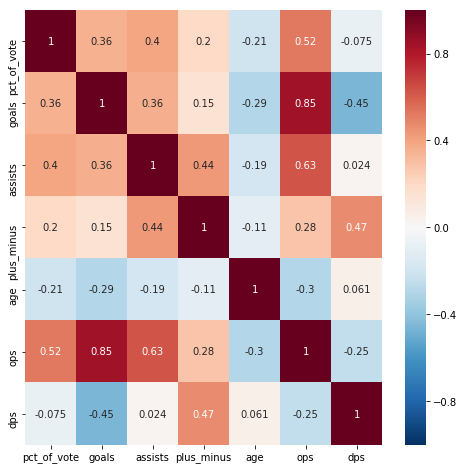

In [362]:
fd = skaters
features= ['pct_of_vote','goals','assists','plus_minus','age','ops','dps','pos']
fd = fd[features]
f = fd.corr()
plt.figure(figsize=(len(features),len(features)))

sns.heatmap(f,annot=True,cmap="RdBu_r",vmin=-1,vmax=1);

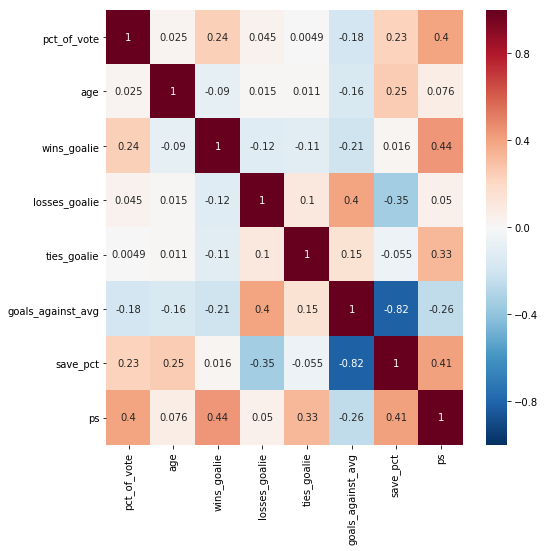

In [363]:
fd = goalies
features= ['pct_of_vote','age','wins_goalie','losses_goalie',
           'ties_goalie','goals_against_avg','save_pct','ps']
fd = fd[features]
f = fd.corr()
plt.figure(figsize=(len(features),len(features)));

sns.heatmap(f,annot=True,cmap="RdBu_r",vmin=-1,vmax=1);

We can expect from the plots above that directly fitting a model to the available data might be challenging.

In [364]:
fd = full_data.copy()
# prepare for applying model:
# 1) preprocessing-scale
# t = fd.drop(["Year"],axis=1).select_dtypes(exclude=["object"]).apply(sklearn.preprocessing.scale)
# fd[t.columns] = t
# actually its incorrect to preprocess the entire data set. this results in data contamination


# 2) one-hot encode positions
fd=pd.get_dummies(fd,columns=['pos'])

fd[fd["Year"]==2018]
# full_data.sample(10)
# fd.pct_of_vote.plot.hist()


,Year,player,age,team_id,votes,pct_of_vote,goals,assists,points,plus_minus,wins_goalie,losses_goalie,ties_goalie,goals_against_avg,save_pct,ops,dps,gps,ps,ga,pos_C,pos_D,pos_G,pos_LW,pos_RW
1038,2018,Taylor Hall,26,New Jersey Devils,1264,77.07,39,54,93,14.0,0.0,0.0,0.0,0.0,0.0,9.9,2.3,0.0,12.2,64.804070,0,0,0,1,0
1039,2018,Nathan MacKinnon,22,Colorado Avalanche,1194,72.80,39,58,97,11.0,0.0,0.0,0.0,0.0,0.0,10.0,2.2,0.0,12.2,69.604372,1,0,0,0,0
1040,2018,Anze Kopitar,30,Los Angeles Kings,551,33.60,35,57,92,21.0,0.0,0.0,0.0,0.0,0.0,7.9,3.1,0.0,11.0,61.388471,1,0,0,0,0
1041,2018,Claude Giroux,30,Philadelphia Flyers,546,33.29,34,68,102,28.0,0.0,0.0,0.0,0.0,0.0,9.0,2.8,0.0,11.8,71.142930,1,0,0,0,0
1042,2018,Connor McDavid,21,Edmonton Oilers,270,16.46,41,67,108,20.0,0.0,0.0,0.0,0.0,0.0,10.5,2.6,0.0,13.1,84.528386,1,0,0,0,0
1043,2018,Nikita Kucherov,24,Tampa Bay Lightning,166,10.12,39,61,100,15.0,0.0,0.0,0.0,0.0,0.0,9.8,1.8,0.0,11.6,73.204598,0,0,0,0,1
1044,2018,Evgeni Malkin,31,Pittsburgh Penguins,97,5.91,42,56,98,16.0,0.0,0.0,0.0,0.0,0.0,10.2,2.2,0.0,12.4,72.373777,1,0,0,0,0
1045,2018,Blake Wheeler,31,Winnipeg Jets,69,4.21,23,68,91,13.0,0.0,0.0,0.0,0.0,0.0,7.1,2.1,0.0,9.2,48.126100,0,0,0,0,1
1046,2018,Alex Ovechkin,32,Washington Capitals,37,2.26,49,38,87,3.0,0.0,0.0,0.0,0.0,0.0,9.3,1.9,0.0,11.2,57.295907,0,0,0,1,0


In [365]:


model_features = [ u'age', u'goals', u'assists',  u'plus_minus',
       u'wins_goalie', u'losses_goalie', u'ties_goalie', u'goals_against_avg',
       u'save_pct', u'ops', u'dps', u'gps', u'pos_G', u'ga']

# Use all years 2015 and prior for training, and try to predict the previous three years.
target_yr = 2015
train=fd[fd["Year"]<=target_yr]
test=fd[fd["Year"] > target_yr]


# Prepare a holdout of the train set to use for blending. 
base, cv = train_test_split(train,test_size=0.1)

x_test = test[model_features]
y_test = test.pct_of_vote

x_base = base[model_features]
y_base = base.pct_of_vote

x_cv = cv[model_features]
y_cv = cv.pct_of_vote


# x_base and y_base will be used to fit the base models
# then make predictions for y_holdout using x_holdout
# those predictions are used to train the stacker




# # scaling preprocessing the data. I'm not sure if it's actually a good idea to do this
# # Leave it out for now.

# t = x_base.drop(["pos_G"],axis=1).select_dtypes(exclude=["object"]).apply(sklearn.preprocessing.scale)
# x_base[t.columns] = t

# t = x_holdout.drop(["pos_G"],axis=1).select_dtypes(exclude=["object"]).apply(sklearn.preprocessing.scale)
# x_holdout[t.columns] = t

# t = x_test.drop(["pos_G"],axis=1).select_dtypes(exclude=["object"]).apply(sklearn.preprocessing.scale)
# x_test[t.columns] = t

In [366]:
# Wrapper class for sklearn models
# It trains on logarithmically renormalized vote_pct, rather than raw.
# This is because heuristically the vote share by player
# in any given year is approximately exponentially decaying
# so it made sense to me to try to make the data more regular by taking the log.
class SklearnWrapper(object):
    def __init__(self,clf,seed=0,params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
        
    def __str__(self):
        return str(type(self.clf))
        
    # automatically does log conversion in train and predict
    def train(self,x_train,y_train):
        self.clf.fit(x_train,np.log(y_train))
        
    def predict(self,x):
        return np.exp(self.clf.predict(x))
    
    def feature_importances(self):
        print(clf.feature_importances_)
        
    
        
def get_base_predictions(clf):

    clf.train(x_base,y_base)
    return clf.predict(x_cv)
    
# Wrapper for xgboost from sklearn courtesy of https://www.kaggle.com/mmueller/stacking-starter
class XgbWrapper(object):
    def __init__(self, seed=0, params=None):
        self.param = params
        self.param['seed'] = seed
        self.nrounds = params.pop('nrounds', 250)

    def train(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, label=np.log(y_train))
        self.gbdt = xgb.train(self.param, dtrain, self.nrounds)

    def predict(self, x):
        return np.exp(self.gbdt.predict(xgb.DMatrix(x)))
        



In [367]:
#Try several models

# Put in our parameters. For now these values are the same as those in 
# https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python

# Random Forest parameters
et_params = {
    'n_jobs': -1,
    'n_estimators': 100,
    'max_features': 0.5,
    'max_depth': 6,
    'min_samples_leaf': 2,
}

rf_params = {
    'n_jobs': -1,
    'n_estimators': 100,
    'max_features': 0.6,
    'max_depth': 6,
    'min_samples_leaf': 2,
}


# Gradient Boosting parameters
gb_params = {
    'n_estimators': 100,
     'max_features': 0.2,
    'max_depth': 4,
    'min_samples_leaf': 2,
    'verbose': 0
}



mlp_params = {
    'hidden_layer_sizes': (4,4,2),
    'alpha': 0.2
}

SEED = 0

# Train two versions of each model, one on vote_pct, and one on log_vote_pct
# for convenience, also generate predictions for the test data to use later

forest = SklearnWrapper(clf=RandomForestRegressor,seed=SEED,params=rf_params)
# print("Forest Regressor MAE on training data: %f"% mean_absolute_error(forest.predict(x_holdout),y_holdout))

gbm = SklearnWrapper(clf=XGBRegressor,seed=SEED,params=gb_params)
# print("XGBRegressor MAE on training data: %f"% mean_absolute_error(gbm.predict(x_holdout),y_holdout))

mlp = SklearnWrapper(clf=MLPRegressor,seed=SEED,params=mlp_params)
# print("MLPRegressor MAE on training data: %f"% mean_absolute_error(mlp.predict(x_holdout),y_holdout))

et = SklearnWrapper(clf=ExtraTreesRegressor,seed=SEED,params=et_params)
# print("Extra Trees Regressor MAE on training data: %f"% mean_absolute_error(et.predict(x_holdout),y_holdout))


         rf        xgb         et       mlp
0  8.762283   8.433738  10.103207  7.989197
1  8.635564  12.619729   9.183857  7.429875
2  6.619139   5.093350   7.301396  3.307526
3  6.845717  19.377037   8.197063  3.769081
4  6.771828   5.482269   8.214711  4.367600


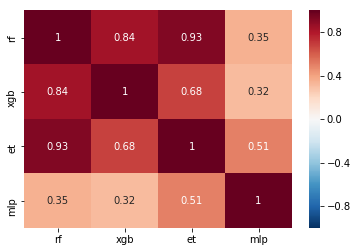

In [368]:
# use XGBoost to blend the base models
    
cv_predictions = pd.DataFrame()

cv_predictions["rf"] = get_base_predictions(forest)
cv_predictions["xgb"] = get_base_predictions(gbm)
cv_predictions["et"] = get_base_predictions(et)
cv_predictions["mlp"] = get_base_predictions(mlp)
# cv_predictions["truth"] = np.array(y_cv)


# look at correlation map of base predictions
plt.figure()
z = cv_predictions.corr()
sns.heatmap(z,annot=True,cmap="RdBu_r",vmin=-1,vmax=1);

# the models are decently correlated with each other. 
# this is not ideal, but that's life

print(cv_predictions.head())


In [369]:
# train the ensemble 
xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.7,
    'silent': 1,
    'subsample': 0.7,
    'learning_rate': 0.3,
    'max_depth': 5,
    'num_parallel_tree': 1,
    'min_child_weight': 1,
    'eval_metric': 'mae',
    'nrounds': 150,
    'lambda': 1
}

stack = XgbWrapper(seed=SEED,params=xgb_params)

stack.train(cv_predictions,y_cv)
print("Averaged MAE of stack %f" % mean_absolute_error(stack.predict(cv_predictions),y_cv))
print("Averaged MAE of rf %f" % mean_absolute_error(forest.predict(x_cv),y_cv))
print("Averaged MAE of et %f" % mean_absolute_error(et.predict(x_cv),y_cv))
print("Averaged MAE of mlp %f" % mean_absolute_error(mlp.predict(x_cv),y_cv))
print("Averaged MAE of gbm %f" % mean_absolute_error(gbm.predict(x_cv),y_cv))

Averaged MAE of stack 0.012228
Averaged MAE of rf 9.862691
Averaged MAE of et 12.249697
Averaged MAE of mlp 14.573573
Averaged MAE of gbm 11.620483


There just is not enough data in the cv set, xgboost just memorizes the whole thing. 
I expect that if we use a kfold approach on the whole training set for xgboost stacking as well we can solve or at least mitigate the high variance this method suffers from. 

Averaged MAE of stack 18.113582
Averaged MAE of rf 18.751752
Averaged MAE of et 19.815677
Averaged MAE of mlp 22.670162
Averaged MAE of gbm 17.180748


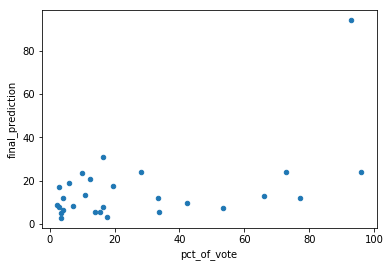

<Figure size 1152x1152 with 0 Axes>

<Figure size 432x288 with 0 Axes>

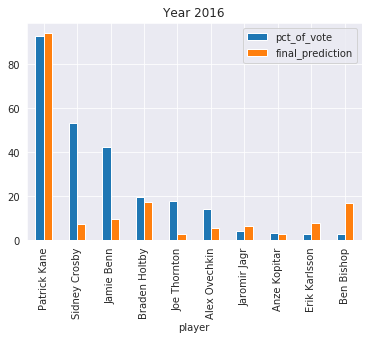

<Figure size 432x288 with 0 Axes>

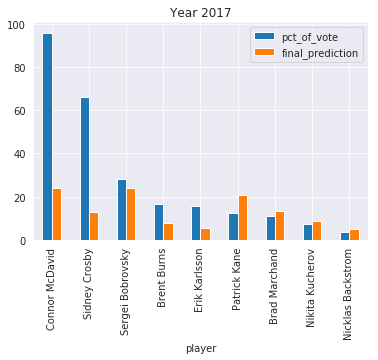

<Figure size 432x288 with 0 Axes>

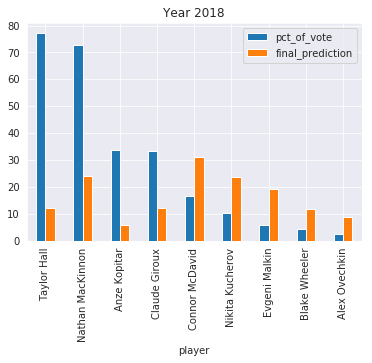

In [370]:
# feature importances, out of curiosity
# print zip(lvl1_predictions.columns,stack.feature_importances)


# prepare input predictions for blender
x_test_lvl2 = pd.DataFrame(columns = {
                                          })

x_test_lvl2["rf"] = forest.predict(x_test)
x_test_lvl2["xgb"] = gbm.predict(x_test)
x_test_lvl2["et"] = et.predict(x_test)
x_test_lvl2["mlp"] = mlp.predict(x_test)










test["final_prediction"] = stack.predict(x_test_lvl2)

# fig = plt.figure()



test.plot.scatter(x='pct_of_vote',y='final_prediction')

fig = plt.figure(figsize=(16,16))

# g = sns.FacetGrid(test,col="Year",height=6,orientation="h")
# g.map(sns.barplot, 'player','pct_of_vote')
# sns.catplot(x='player', y = 'pct_of_vote',data=test,kind='bar',row='Year',sharex=False,height=14)


# its annoyingly difficult to make a facetgrid to show the three years
with sns.axes_style("darkgrid"):
    for year in [2016,2017,2018]:
        t = test[test['Year']==year]
        fig = plt.figure()
        t[['player','pct_of_vote','final_prediction']].head(10).plot.bar(x='player')
        plt.title("Year %i" % year)

    

print("Averaged MAE of stack %f" % mean_absolute_error(test["final_prediction"],y_test))
print("Averaged MAE of rf %f" % mean_absolute_error(forest.predict(x_test),y_test))
print("Averaged MAE of et %f" % mean_absolute_error(et.predict(x_test),y_test))
print("Averaged MAE of mlp %f" % mean_absolute_error(mlp.predict(x_test),y_test))
print("Averaged MAE of gbm %f" % mean_absolute_error(gbm.predict(x_test),y_test))

Some years, such as 2018, are particularly unkind. After a brief investigation, our model seems to strongly overweigh goals, which is not an unreasonable thing to do. The model just sees the statistics in a vacuum, and has no idea about the team's record during that year, or advanced statistics such as WAR that more directly quantify how useful a player was to their team. So there is clearly room for improvement here. Case in point, in 2018 Connor McDavid literally had higher everything than Taylor hall. Why did Taylor Hall crush McDavid in the voting? Part of the answer is probably that the Oilers were terrible in 2018, not even making the playoffs. As for the rest, only the hockey gods can say. One final comment is that the performance of this model seems to vary quite a bit with random train/holdout splits.

In [371]:
idx1 = (test.player=="Connor McDavid") & (test.Year == 2018)
idx2 = (test.player=="Taylor Hall") & (test.Year == 2018)
idx3 = (test.player=="Nathan MacKinnon") & (test.Year == 2018)
test[idx1 | idx2 | idx3]


,Year,player,age,team_id,votes,pct_of_vote,goals,assists,points,plus_minus,wins_goalie,losses_goalie,ties_goalie,goals_against_avg,save_pct,ops,dps,gps,ps,ga,pos_C,pos_D,pos_G,pos_LW,pos_RW,final_prediction
1038,2018,Taylor Hall,26,New Jersey Devils,1264,77.07,39,54,93,14.0,0.0,0.0,0.0,0.0,0.0,9.9,2.3,0.0,12.2,64.804070,0,0,0,1,0,12.241899
1039,2018,Nathan MacKinnon,22,Colorado Avalanche,1194,72.80,39,58,97,11.0,0.0,0.0,0.0,0.0,0.0,10.0,2.2,0.0,12.2,69.604372,1,0,0,0,0,23.854269
1042,2018,Connor McDavid,21,Edmonton Oilers,270,16.46,41,67,108,20.0,0.0,0.0,0.0,0.0,0.0,10.5,2.6,0.0,13.1,84.528386,1,0,0,0,0,31.001682


In [372]:
#Make the plotting nicer by only using the last names
surnames = [re.search('\w+ (\w+)', name).group(1) for name in test["player"]]
test["player_surname"] = surnames

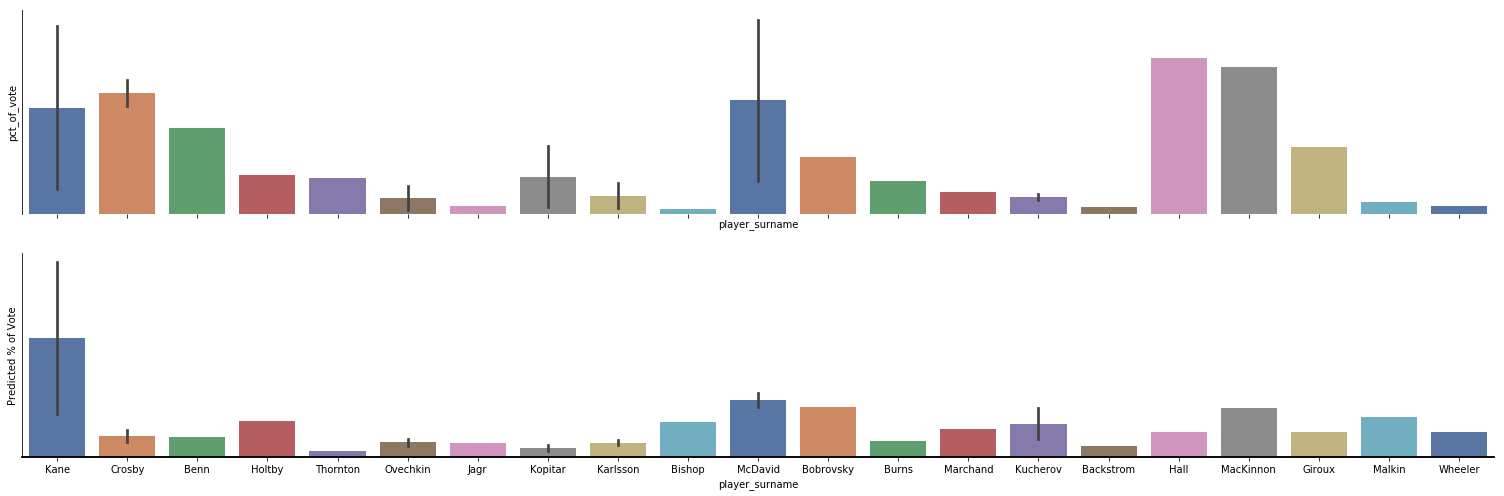

In [373]:
#Showing all three years together
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(21, 7), sharex=True)

# sns.barplot(x='pct_of_vote', y='final_prediction', data=test[test.loc[:,"Year"]==2017], palette="vlag", ax=ax2)
sns.barplot(x='player_surname', y='pct_of_vote', data=test, palette="deep", ax=ax1)
ax2.axhline(0, color="k", clip_on=False)
ax2.set_ylabel("% of Vote")

# sns.barplot(x='player', y='final_prediction', data=test[test.loc[:,"Year"]==2018], palette="deep", ax=ax3)
sns.barplot(x='player_surname', y='final_prediction', data=test, palette="deep", ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set_ylabel("Predicted % of Vote")

# Finalize the plot
sns.despine(bottom=True)
plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)

Trying again with kfold approach rather than 10% holdout from training set

In [374]:
fd = full_data.copy()
fd=pd.get_dummies(fd,columns=['pos'])
target_yr = 2015

# train = fd[fd["Year"] <= target_yr]
# test = fd[fd["Year"] > target_yr]

train,test = train_test_split(fd,test_size=0.25)


X_train, X_test = train[model_features], test[model_features]
y_train, y_test = train["pct_of_vote"], test["pct_of_vote"]

ntrain = train.shape[0]
ntest = test.shape[0]
nfolds = 5

def get_base_predictions(clf):

    clf.train(X_train,y_train)
    return clf.predict(X_test)

In [375]:
kf = KFold(n_splits=nfolds,shuffle=True)

In [376]:
def get_oof_predictions(clf):
    infold_train = np.zeros((ntrain,))
    infold_train_byfold = np.zeros((nfolds,ntrain))
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_byfold = np.zeros((nfolds,ntest))
    
    for i, (train_idx, cv_idx) in enumerate(kf.split(X_train)):
        x_tr = X_train.iloc[train_idx]
        x_cv = X_train.iloc[cv_idx]
        y_tr = y_train.iloc[train_idx]
        
        clf.train(x_tr,y_tr)
        
        # use n-1 fold to make prediction for i'th fold 
        oof_train[cv_idx] = clf.predict(x_cv)
        infold_train_byfold[i,train_idx] = clf.predict(x_tr)
        
        # also make predictions for the test data. since
        # we have nfolds different models trained on the different
        # fold combinations, we can just average them together to 
        # get their prediction on the test set
        oof_test_byfold[i,:] = clf.predict(X_test)
    
    oof_test[:] = oof_test_byfold.mean(axis=0)
    infold_train[:] = infold_train_byfold.mean(axis=0)*nfolds/(nfolds-1) #because we
    # actually only have nfolds-1 predictions for a given fold
    
    return infold_train.reshape(-1,1), oof_train.reshape(-1,1), oof_test.reshape(-1,1)

    
# seems to be working

In [377]:
for clf in [forest, et, gbm, mlp]:
    print("Train error of %s: %.2f" % (clf,mean_absolute_error(get_oof_predictions(clf)[0],y_train)))
    print("OOF (CV) error of %s: %.2f" % (clf,mean_absolute_error(get_oof_predictions(clf)[1],y_train)))
    print("Test error of %s: %.2f \n" % (clf,mean_absolute_error(get_oof_predictions(clf)[2],y_test)))

Train error of <class 'sklearn.ensemble.forest.RandomForestRegressor'>: 9.40
OOF (CV) error of <class 'sklearn.ensemble.forest.RandomForestRegressor'>: 13.07
Test error of <class 'sklearn.ensemble.forest.RandomForestRegressor'>: 15.16 

Train error of <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>: 11.80
OOF (CV) error of <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>: 13.67
Test error of <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>: 15.59 

Train error of <class 'xgboost.sklearn.XGBRegressor'>: 5.02
OOF (CV) error of <class 'xgboost.sklearn.XGBRegressor'>: 13.73
Test error of <class 'xgboost.sklearn.XGBRegressor'>: 14.73 

Train error of <class 'sklearn.neural_network.multilayer_perceptron.MLPRegressor'>: 17.26
OOF (CV) error of <class 'sklearn.neural_network.multilayer_perceptron.MLPRegressor'>: 17.32
Test error of <class 'sklearn.neural_network.multilayer_perceptron.MLPRegressor'>: 17.57 



That's a fairly reasonable result. The random forest, extra trees, and MLP are generalizing well. XGBRegressor is suffering from high variance (although it's performance on CV and test data is still in line with the other models), and MLP might be suffering from slightly high bias. All of these models can stand to be improved by doing a hyperparameter grid search. But let's see what we can accomplish by stacking these models with XGBoost with a larger training data.

In [378]:
meta_train = pd.DataFrame()
meta_test = pd.DataFrame()
for (name,clf) in [("rf",forest), ("et",et), ("gbm",gbm), ("mlp",mlp)]:
    infold_train, oof_train, oof_test = get_oof_predictions(clf)
    meta_train[name] = np.squeeze(oof_train)
    meta_test[name] = get_base_predictions(clf)

In [379]:
#just out of curiosity, a general look at how our base models are doing
pd.concat([meta_train,y_train.reset_index(drop=True)],axis=1).head(20)

,rf,et,gbm,mlp,pct_of_vote
0,17.291157,16.113392,19.057785,10.874184,21.27
1,13.328797,11.724865,10.540788,7.674621,12.59
2,80.467278,77.910761,77.939079,218.121453,96.19
3,6.211642,7.839213,3.348824,6.457276,4.21
4,8.370029,8.473915,4.157517,2.909890,49.50
5,10.037694,15.715441,4.785076,5.553395,14.20
6,39.518798,28.010693,78.150085,10.584672,16.90
7,7.108870,8.226667,5.229949,4.582827,3.55
8,7.990763,6.866304,4.752943,4.092790,4.81
9,9.145168,11.362471,13.489959,20.020179,7.79


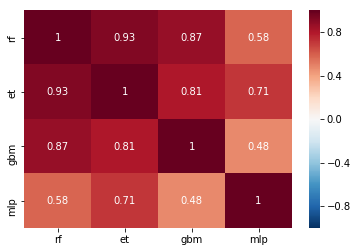

In [380]:
# correlation of base models
plt.figure()
z = meta.corr()
sns.heatmap(z,annot=True,cmap="RdBu_r",vmin=-1,vmax=1);

In [381]:
# now train the stack, again using kfold with the same folds for cross validation
xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.7,
    'silent': 1,
    'subsample': 0.7,
    'learning_rate': 0.3,
    'max_depth': 3,
    'num_parallel_tree': 3,
    'min_child_weight': 1,
    'eval_metric': 'mae',
    'nrounds': 10,
    'lambda': 1
}

stack = XgbWrapper(seed=SEED,params=xgb_params)


# the easiest thing to do is to train the stack on the full training data 
# and see how it performs on the test data
stack.train(meta_train,y_train)
print("MAE of stack on train data %.2f" % mean_absolute_error(y_train,stack.predict(meta_train)))
print("MAE of stack on test data %.2f" % mean_absolute_error(y_test,stack.predict(meta_test)))

MAE of stack on train data 11.71
MAE of stack on test data 15.44


The stack achieves a small but definite improvement over every base model. 